<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
#Start Here

In [1]:
data_path = "/home/alex/data/lambdaschool/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"

In [16]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import spacy

nlp = spacy.load("en_core_web_lg")

import pandas as pd

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import seaborn as sns


# Load review data

In [4]:
df = pd.read_csv(data_path)

print(df.shape)
df.head()

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


# Display breakdown of reviews by primary category type (expressed as percent of total review count)

In [6]:
df["primaryCategories"].value_counts(dropna=False, normalize=True)*100

Electronics                    49.396442
Health & Beauty                42.605534
Toys & Games,Electronics        5.915572
Office Supplies,Electronics     1.362417
Electronics,Media               0.652972
Office Supplies                 0.031766
Animals & Pet Supplies          0.021177
Electronics,Furniture           0.007059
Home & Garden                   0.007059
Name: primaryCategories, dtype: float64

In [9]:
electronics_df = df[df["primaryCategories"] == "Health & Beauty"].copy()
print(electronics_df.shape)
electronics_df.head()

(12071, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


# Tokenize review text data as lemmas

In [15]:
electronics_df["reviews.text"]

0        I order 3 of them and one of the item is bad q...
1        Bulk is always the less expensive way to go fo...
2        Well they are not Duracell but for the price i...
3        Seem to work as well as name brand batteries a...
4        These batteries are very long lasting the pric...
                               ...                        
12081    They are batteries and as such work just as ex...
12082                                                 Yup!
12083                                      Yup. Batteries.
12084                           Yup. Batteries. They work.
12085    I ordered this car for my son not really knowi...
Name: reviews.text, Length: 12071, dtype: object

In [30]:
electronics_df["reviews.text"].str.contains("batter*").value_counts()

False    6470
True     5601
Name: reviews.text, dtype: int64

In [33]:
CUSTOM_STOPWORDS = STOPWORDS.union(set(['battery', "batteries"]))

In [34]:
tokens = []

for doc in nlp.pipe(electronics_df["reviews.text"]):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.text.lower() not in CUSTOM_STOPWORDS) and (token.is_stop != True) and (token.pos_ != 'PRON')) and (token.is_punct !=True) and (token.is_space != True):
            doc_tokens.append(token.lemma_.strip())
            
    tokens.append(doc_tokens)

In [35]:
len(tokens) == electronics_df.shape[0]

True

In [36]:
id2word = corpora.Dictionary(tokens)
len(id2word.keys())

5233

In [37]:
id2word.filter_extremes(no_below=5, no_above=.95)
len(id2word.keys())

1405

In [38]:
LDA_corpora = [id2word.doc2bow(doc) for doc in tokens]

In [39]:
lda = LdaMulticore(corpus=LDA_corpora,
                  id2word=id2word,
                  num_topics=15, 
                  passes=100)

words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]

topics = [' '.join(t[0:5]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
toy great deal kid item

------ Topic 1 ------
Duracell Amazon like power cost

------ Topic 2 ------
remote month week 2 use

------ Topic 3 ------
expect excellent ok Amazon Basics

------ Topic 4 ------
box come package nice packaging

------ Topic 5 ------
value great product love Amazon

------ Topic 6 ------
use mouse time light review

------ Topic 7 ------
need order buy Amazon thank

------ Topic 8 ------
fast charge hold quality high

------ Topic 9 ------
good price far deal quality

------ Topic 10 ------
long brand last time buy

------ Topic 11 ------
great price buy quality product

------ Topic 12 ------
life brand Amazon AmazonBasics buy

------ Topic 13 ------
brand price work well beat

------ Topic 14 ------
work great fine like brand



In [40]:
pyLDAvis.gensim.prepare(lda,LDA_corpora,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.205301  0.069651       1        1  9.947902
10    -0.107728 -0.171365       2        1  8.663153
7     -0.118240  0.038670       3        1  8.604945
1     -0.159119 -0.050914       4        1  8.072919
12    -0.081688 -0.056158       5        1  7.901110
6     -0.203550  0.093923       6        1  7.590583
4     -0.092945  0.075683       7        1  6.817623
9      0.202028 -0.226666       8        1  6.412707
0      0.040082  0.145501       9        1  6.036277
11     0.350911  0.039154      10        1  5.992686
13     0.073029 -0.229943      11        1  5.842999
14     0.101928 -0.063947      12        1  5.689347
5      0.246530  0.270404      13        1  4.758061
8     -0.014559 -0.070488      14        1  4.703202
3     -0.031376  0.136497      15        1  2.966493, topic_info=          Term         Freq        Total Category  logprob  loglift
29        good  3144.000000  3144.000000  Default  30.0000  30.0000
7         work  2649.000000  2649.000000  Default  29.0000  29.0000
18       great  3595.000000  3595.000000  Default  28.0000  28.0000
15       price  2983.000000  2983.000000  Default  27.0000  27.0000
20        long  2030.000000  2030.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
137  recommend    18.161459   292.900787  Topic15  -4.9584   0.7373
701       soon    12.253781    58.898743  Topic15  -5.3518   1.9478
6      quality    15.887371   723.597839  Topic15  -5.0921  -0.3009
26         buy    15.663928  1925.783813  Topic15  -5.1063  -1.2939
344         go    14.039557   352.155945  Topic15  -5.2158   0.2956

[887 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1177     12  0.161713   1.61
1177     15  0.646853   1.61
903       6  0.943185    1/2
1370      3  0.890049    1/3
1247      3  0.890036     14
...     ...       ...    ...
88        9  0.096037   year
749       9  0.882615  young
749      14  0.063044  young
886      14  0.905565    yup
1095      7  0.925473   zero

[1878 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 8, 2, 13, 7, 5, 10, 1, 12, 14, 15, 6, 9, 4])

In [41]:
distro = [lda[d] for d in LDA_corpora]

In [42]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

doc_topics = pd.DataFrame.from_records(new_distro)
doc_topics.columns = topics

doc_topics.head()

,toy great deal kid item,Duracell Amazon like power cost,remote month week 2 use,expect excellent ok Amazon Basics,box come package nice packaging,value great product love Amazon,use mouse time light review,need order buy Amazon thank,fast charge hold quality high,good price far deal quality,long brand last time buy,great price buy quality product,life brand Amazon AmazonBasics buy,brand price work well beat,work great fine like brand
0,0.000000,0.000000,0.303649,0.000000,0.279655,0.000000,0.000000,0.216956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118253
1,0.011111,0.011111,0.011111,0.011111,0.011111,0.187354,0.011111,0.668198,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111
2,0.016667,0.271329,0.016667,0.016667,0.016667,0.266662,0.016667,0.016667,0.016667,0.016667,0.016667,0.262006,0.016667,0.016667,0.016667
3,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.813333,0.013333
4,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.413392,0.413274,0.013333,0.013333,0.013333


In [43]:
doc_topics['primary_topic'] = doc_topics.idxmax(axis=1)
doc_topics['primary_topic'].value_counts()

good price far deal quality           1343
great price buy quality product       1340
long brand last time buy              1138
work great fine like brand            1032
value great product love Amazon        906
toy great deal kid item                884
remote month week 2 use                748
brand price work well beat             747
need order buy Amazon thank            746
life brand Amazon AmazonBasics buy     664
Duracell Amazon like power cost        537
fast charge hold quality high          529
use mouse time light review            517
box come package nice packaging        513
expect excellent ok Amazon Basics      427
Name: primary_topic, dtype: int64

In [45]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [46]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=LDA_corpora,
                                                        start=3, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=1)

In [47]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,3,-2.492799
1,0,5,-2.573251
2,0,7,-2.547095
3,0,9,-2.518329
4,0,11,-2.655446


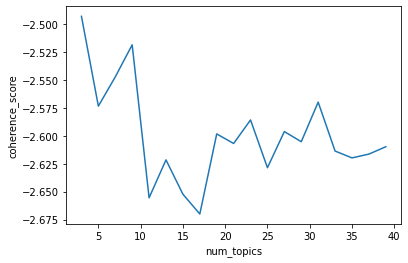

In [48]:
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# Reduce number of topics from 15 to 9

In [49]:
lda = LdaMulticore(corpus=LDA_corpora,
                  id2word=id2word,
                  num_topics=9, 
                  passes=100)

words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]

topics = [' '.join(t[0:5]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
work good far fine expect

------ Topic 1 ------
great price work deal box

------ Topic 2 ------
product great Amazon price long

------ Topic 3 ------
value great long good love

------ Topic 4 ------
use buy day week month

------ Topic 5 ------
brand cheap buy long Amazon

------ Topic 6 ------
brand purchase long order AA

------ Topic 7 ------
toy use remote power light

------ Topic 8 ------
good price buy quality product



## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling